<a href="https://colab.research.google.com/github/Ran147/Project_T/blob/main/Fase_3_FINAL_VERFR_face_recognition__estudiantes_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: [Johan Rodríguez](https://github.com/Johanx22x)

Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [1]:
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
!pip install pytz
import datetime
import pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=7bf8e78e9a2f8bc75fdf86d362868858ee33aac3bd2797756e4f45a113cf31e7
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [72]:
from IPython.display import HTML

# Utils

## In-memory data

In [2]:
import pickle

In [3]:
registered_faces = {}
registered_professor = []
registered_student = []
registered_miscelaneous = []
registered_class = []
registered_course = []
registered_attendance = []
registered_students_in_courses = []

In [4]:
attendance_list0 = []
attendance_list2 = []
attendance_list3 = []

In [44]:
with open('caritas.bin', 'ab') as file:
  pickle.dump(registered_faces, file)


##Save info

In [5]:
local_tz = pytz.timezone('America/Costa_Rica')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('caritas.bin', 'rb') as file:
  sumito = pickle.load(file)
registered_faces.update(sumito)
with open("infoprofesores.bin", "rb") as file:
  informaciondelprofesorado = pickle.load(file)
  for pr in informaciondelprofesorado:
    registered_professor.append(pr)
with open("infoestudiantes.bin", "rb") as file:
  informaciondelestudiantado = pickle.load(file)
  for es in informaciondelestudiantado:
    registered_student.append(es)
with open("infomisc.bin", "rb") as file:
  informaciondelmiscelaneado = pickle.load(file)
  for mi in informaciondelmiscelaneado:
    registered_miscelaneous.append(mi)
with open("infoaulas.bin", "rb") as file:
  informaciondelaula = pickle.load(file)
  for au in informaciondelaula:
    registered_class.append(au)
with open("infocursos.bin", "rb") as file:
  informaciondelcurso = pickle.load(file)
  for cu in informaciondelcurso:
    registered_course.append(cu)



In [6]:
class Estudiante:
    def __init__(self, name, id, age, birthday, nationality, phone_number, emails, address, carreer, marital_status):
        self.name = name
        self.id = id
        self.age = age
        self.birthday = birthday
        self.nationality = nationality
        self.phone_number = phone_number
        self.emails = emails
        self.address = address
        self.carreer = carreer
        self.marital_status = marital_status
class Profesor:
  def __init__(self, name, id, age, birthday, nationality, phone_number, emails, address, specialty, marital_status):
        self.name = name
        self.id = id
        self.age = age
        self.birthday = birthday
        self.nationality = nationality
        self.phone_number = phone_number
        self.emails = emails
        self.address = address
        self.specialty = specialty
        self.marital_status = marital_status

class Miscelaneo:
  def __init__(self, name, id, age, birthday, nationality, phone_number, emails, address, schedule, marital_status):
        self.name = name
        self.id = id
        self.age = age
        self.birthday = birthday
        self.nationality = nationality
        self.phone_number = phone_number
        self.emails = emails
        self.address = address
        self.schedule = schedule
        self.marital_status = marital_status

class Aula:
  def __init__(self, numero_aula, condicion, sillas, limpieza):
    self.numero_aula = numero_aula
    self.condicion = condicion
    self.sillas = sillas
    self.limpieza = limpieza

class Curso:
  def __init__(self, codigo_curso, nombre_curso, periodo, carrera, lista_estudiantes, lista_profesores, horario, aula):
    self.codigo_curso = codigo_curso
    self.nombre_curso = nombre_curso
    self.periodo = periodo
    self.carrera = carrera
    self.lista_estudiantes = lista_estudiantes
    self.lista_profesores = lista_profesores
    self.horario = horario
    self.aula = aula







In [7]:
class Asistencia:
  def __init__(self, nombre, path, hora):
    self.nombre = nombre
    self.path = path
    self.hora = hora

## face recognition

In [8]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [9]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [10]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register profesor, student, miscelaneous, classroom and course

## Registrar rostro de profesores

In [11]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)


### Registrar informacion de profesores

In [ ]:
def profesor():
    # Widget for text input
    text_input = widgets.Text(description="Identification:")
    display(text_input)

    # Widget for date input
    date_input = widgets.DatePicker(description="Birthday:")
    display(date_input)

    # Widget for integer input
    age_input = widgets.IntText(description="Age:")
    display(age_input)

    nationality_input = widgets.Text(description="Nationality:")
    display(nationality_input)

    # Create an accordion widget to hold the phonebook
    phonebook_accordion = widgets.Accordion()
    phonebook_accordion.set_title(0, 'Phone Book')

    # Create a button to add phone numbers
    add_phone_button = widgets.Button(description="Add Phone Number")

    phonebook = {}  # Dictionary to store phone numbers

    def add_phone_number(_):
        name = input_name.value
        phone_number = input_phone.value
        phonebook[name] = phone_number

    # Widget for text input (name)
    input_name = widgets.Text(description="Contact Name:")
    # Widget for text input (phone number)
    input_phone = widgets.Text(description="Phone Number:")

    add_phone_button.on_click(add_phone_number)

    # Organize widgets in an accordion
    phonebook_accordion.children = [widgets.VBox([input_name, input_phone, add_phone_button])]

    display(phonebook_accordion)

    email_list = []  # List to store emails

    # Create an accordion widget to hold emails
    email_accordion = widgets.Accordion()
    email_accordion.set_title(0, 'Emails')

    # Create a button to add emails
    add_email_button = widgets.Button(description="Add Email")

    def add_email(_):
        email = input_email.value
        email_list.append(email)

    # Widget for text input (email)
    input_email = widgets.Text(description="Email Address:")

    add_email_button.on_click(add_email)

    # Organize widgets in an accordion
    email_accordion.children = [widgets.VBox([input_email, add_email_button])]

    display(email_accordion)

    address_input = widgets.Text(description="Address:")
    display(address_input)

    specialty_input = widgets.Text(description="Specialty:")
    display(specialty_input)

    marital_status_input = widgets.Text(description="Marital Status:")
    display(marital_status_input)

    # Create a button to submit the form
    submit_button = widgets.Button(description="Submit")

    def submit_form(_):
        # Retrieve values from widgets
        id = text_input.value
        birthday = date_input.value
        age = age_input.value
        nationality = nationality_input.value
        address = address_input.value
        specialty = specialty_input.value
        marital_status = marital_status_input.value

        # Create Profesor instance
        elprofesor = Profesor(
            name=registered_name,
            id=id,
            age=age,
            birthday=birthday,
            nationality=nationality,
            phone_number=phonebook,
            emails=email_list,
            address=address,
            specialty=specialty,
            marital_status=marital_status
        )

        # Load existing professor information, if any
        try:
            with open("infoprofesores.bin", "rb") as file:
                profes = pickle.load(file)
        except FileNotFoundError:
            profes = []

        profes.append(elprofesor)  # Append the new professor to the list

        # Save the updated list back to the file
        with open("infoprofesores.bin", "wb") as file:
            pickle.dump(profes, file)

    submit_button.on_click(submit_form)

    display(submit_button)

# Calls the function
profesor()

Text(value='', description='Identification:')

DatePicker(value=None, description='Birthday:')

IntText(value=0, description='Age:')

Text(value='', description='Nationality:')

Accordion(children=(VBox(children=(Text(value='', description='Contact Name:'), Text(value='', description='Ph…

Accordion(children=(VBox(children=(Text(value='', description='Email Address:'), Button(description='Add Email…

Text(value='', description='Address:')

Text(value='', description='Specialty:')

Text(value='', description='Marital Status:')

Button(description='Submit', style=ButtonStyle())

In [12]:
with open("infoprofesores.bin", "rb") as file:
  informaciondelprofesorado = pickle.load(file)
  for pr in informaciondelprofesorado:
    registered_professor.append(pr)

In [14]:
print(registered_professor)
for h in registered_professor:
  print(h.name)

Messi


## Registrar rostro de estudiantes

In [16]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)



### Registrar informacion de estudiantes

In [ ]:
def estudiante():
    # Widget for text input
    text_input = widgets.Text(description="Identification:")
    display(text_input)

    # Widget for date input
    date_input = widgets.DatePicker(description="Birthday:")
    display(date_input)

    # Widget for integer input
    age_input = widgets.IntText(description="Age:")
    display(age_input)

    nationality_input = widgets.Text(description="Nationality:")
    display(nationality_input)

    # Create an accordion widget to hold the phonebook
    phonebook_accordion = widgets.Accordion()
    phonebook_accordion.set_title(0, 'Phone Book')

    # Create a button to add phone numbers
    add_phone_button = widgets.Button(description="Add Phone Number")

    phonebook = {}  # Dictionary to store phone numbers

    def add_phone_number(_):
        name = input_name.value
        phone_number = input_phone.value
        phonebook[name] = phone_number

    # Widget for text input (name)
    input_name = widgets.Text(description="Contact Name:")
    # Widget for text input (phone number)
    input_phone = widgets.Text(description="Phone Number:")

    add_phone_button.on_click(add_phone_number)

    # Organize widgets in an accordion
    phonebook_accordion.children = [widgets.VBox([input_name, input_phone, add_phone_button])]

    display(phonebook_accordion)

    email_list = []  # List to store emails

    # Create an accordion widget to hold emails
    email_accordion = widgets.Accordion()
    email_accordion.set_title(0, 'Emails')

    # Create a button to add emails
    add_email_button = widgets.Button(description="Add Email")

    def add_email(_):
        email = input_email.value
        email_list.append(email)

    # Widget for text input (email)
    input_email = widgets.Text(description="Email Address:")

    add_email_button.on_click(add_email)

    # Organize widgets in an accordion
    email_accordion.children = [widgets.VBox([input_email, add_email_button])]

    display(email_accordion)

    address_input = widgets.Text(description="Address:")
    display(address_input)

    carreer_input = widgets.Text(description="Carreer:")
    display(carreer_input)

    marital_status_input = widgets.Text(description="Marital Status:")
    display(marital_status_input)

    # Create a button to submit the form
    submit_button = widgets.Button(description="Submit")

    def submit_form(_):
        # Retrieve values from widgets
        id = text_input.value
        birthday = date_input.value
        age = age_input.value
        nationality = nationality_input.value
        address = address_input.value
        carreer = carreer_input.value
        marital_status = marital_status_input.value

        # Create Estudiante instance
        elestudiante = Estudiante(
            name=registered_name,
            id=id,
            age=age,
            birthday=birthday,
            nationality=nationality,
            phone_number=phonebook,
            emails=email_list,
            address=address,
            carreer=carreer,
            marital_status=marital_status
        )

        # Load existing student information, if any
        try:
            with open("infoestudiantes.bin", "rb") as file:
                estus = pickle.load(file)
        except FileNotFoundError:
            estus = []

        estus.append(elestudiante)  # Append the new student to the list

        # Save the updated list back to the file
        with open("infoestudiantes.bin", "wb") as file:
            pickle.dump(estus, file)

    submit_button.on_click(submit_form)

    display(submit_button)

# Calls the function
estudiante()

Text(value='', description='Identification:')

DatePicker(value=None, description='Birthday:')

IntText(value=0, description='Age:')

Text(value='', description='Nationality:')

Accordion(children=(VBox(children=(Text(value='', description='Contact Name:'), Text(value='', description='Ph…

Accordion(children=(VBox(children=(Text(value='', description='Email Address:'), Button(description='Add Email…

Text(value='', description='Address:')

Text(value='', description='Carreer:')

Text(value='', description='Marital Status:')

Button(description='Submit', style=ButtonStyle())

In [17]:
with open("infoestudiantes.bin", "rb") as file:
  informaciondelestudiantado = pickle.load(file)
  for es in informaciondelestudiantado:
    registered_student.append(es)

In [75]:
print(registered_student)
for c in registered_student:
  print(c.carreer)

[<__main__.Estudiante object at 0x791980706b90>, <__main__.Estudiante object at 0x791980742050>]
Ing computation
ing computation


## Registrar miscelaneos

In [19]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)


### Registrar informacion de miscelaneos

In [ ]:
def miscelaneous():
    # Widget for text input
    text_input = widgets.Text(description="Identification:")
    display(text_input)

    # Widget for date input
    date_input = widgets.DatePicker(description="Birthday:")
    display(date_input)

    # Widget for integer input
    age_input = widgets.IntText(description="Age:")
    display(age_input)

    nationality_input = widgets.Text(description="Nationality:")
    display(nationality_input)

    # Create an accordion widget to hold the phonebook
    phonebook_accordion = widgets.Accordion()
    phonebook_accordion.set_title(0, 'Phone Book')

    # Create a button to add phone numbers
    add_phone_button = widgets.Button(description="Add Phone Number")

    phonebook = {}  # Dictionary to store phone numbers

    def add_phone_number(_):
        name = input_name.value
        phone_number = input_phone.value
        phonebook[name] = phone_number

    # Widget for text input (name)
    input_name = widgets.Text(description="Contact Name:")
    # Widget for text input (phone number)
    input_phone = widgets.Text(description="Phone Number:")

    add_phone_button.on_click(add_phone_number)

    # Organize widgets in an accordion
    phonebook_accordion.children = [widgets.VBox([input_name, input_phone, add_phone_button])]

    display(phonebook_accordion)

    email_list = []  # List to store emails

    # Create an accordion widget to hold emails
    email_accordion = widgets.Accordion()
    email_accordion.set_title(0, 'Emails')

    # Create a button to add emails
    add_email_button = widgets.Button(description="Add Email")

    def add_email(_):               # <-agarrar esta logica para la parte de añadir profesores, estudiantes y aulas en la parte de cursos
        email = input_email.value
        email_list.append(email)

    # Widget for text input (email)
    input_email = widgets.Text(description="Email Address:")

    add_email_button.on_click(add_email)

    # Organize widgets in an accordion
    email_accordion.children = [widgets.VBox([input_email, add_email_button])]

    display(email_accordion)

    address_input = widgets.Text(description="Address:")
    display(address_input)

    schedule_input = widgets.Text(description="Shift:")
    display(schedule_input)

    marital_status_input = widgets.Text(description="Marital Status:")
    display(marital_status_input)

    # Create a button to submit the form
    submit_button = widgets.Button(description="Submit")

    def submit_form(_):
        # Retrieve values from widgets
        id = text_input.value
        birthday = date_input.value
        age = age_input.value
        nationality = nationality_input.value
        address = address_input.value
        schedule = schedule_input.value
        marital_status = marital_status_input.value

        # Create Miscelaneo instance
        elmiscelaneo = Miscelaneo(
            name=registered_name,
            id=id,
            age=age,
            birthday=birthday,
            nationality=nationality,
            phone_number=phonebook,
            emails=email_list,
            address=address,
            schedule=schedule,
            marital_status=marital_status
        )

        # Load existing miscellaneous information, if any
        try:
            with open("infomisc.bin", "rb") as file:
                misce = pickle.load(file)
        except FileNotFoundError:
            misce = []

        misce.append(elmiscelaneo)  # Append the new miscellaneous to the list

        # Save the updated list back to the file
        with open("infomisc.bin", "wb") as file:
            pickle.dump(misce, file)

    submit_button.on_click(submit_form)

    display(submit_button)

# Calls the function
miscelaneous()

Text(value='', description='Identification:')

DatePicker(value=None, description='Birthday:')

IntText(value=0, description='Age:')

Text(value='', description='Nationality:')

Accordion(children=(VBox(children=(Text(value='', description='Contact Name:'), Text(value='', description='Ph…

Accordion(children=(VBox(children=(Text(value='', description='Email Address:'), Button(description='Add Email…

Text(value='', description='Address:')

Text(value='', description='Shift:')

Text(value='', description='Marital Status:')

Button(description='Submit', style=ButtonStyle())

In [20]:
with open("infomisc.bin", "rb") as file:
  informaciondelmiscelaneado = pickle.load(file)
  for mi in informaciondelmiscelaneado:
    registered_miscelaneous.append(mi)

In [21]:
print(registered_miscelaneous)
for ct in registered_miscelaneous:
  print(ct.name)

Elon


## Registrar aulas

In [ ]:
def classroom(registered_miscelaneous):
    # Create a list and a dictionary to store information
    schedule_list = []
    final_dict = {}

    # Widget for text input (classroom number)
    classnum_input = widgets.Text(description="Classroom Number:")
    display(classnum_input)

    # Widget for yes/no question (air conditioning)
    classcondition_input = widgets.RadioButtons(options=['yes', 'no'], description="Air Conditioning:")
    display(classcondition_input)

    # Widget for yes/no question (chair condition)
    chairstate_input = widgets.RadioButtons(options=['yes', 'no'], description="Chair Condition:")
    display(chairstate_input)

    # Widget for cleaning schedules
    schedule_output = widgets.Output()

    def add_schedule(_):
        cleaning = schedule_input.value.strip()
        schedule_output.append_stdout(f"Cleaning Schedule: {cleaning}\n")
        schedule_list.append(cleaning)

    schedule_input = widgets.Text(description="Cleaning Schedule:")
    add_schedule_button = widgets.Button(description="Add Schedule")
    add_schedule_button.on_click(add_schedule)

    with schedule_output:
        display(schedule_input, add_schedule_button)

    display(schedule_output)

    # Widget for text input (miscellaneous in charge)
    misceasignado_input = widgets.Text(description="Miscellaneous in Charge:")
    display(misceasignado_input)

    # Widget for submitting the form
    submit_button = widgets.Button(description="Submit")

    def submit_form(_):
        classnum = classnum_input.value.strip()
        classcondition = classcondition_input.value.strip()
        chairstate = chairstate_input.value.strip()
        misceasignado = misceasignado_input.value.strip()

        for i in registered_miscelaneous:
            name = i.name
            if misceasignado != name:
                print("The miscellaneous doesn't exist")
            else:
                final_dict[misceasignado] = schedule_list

        elaula = Aula(classnum, classcondition, chairstate, final_dict)

        # Load existing classroom information, if any
        try:
            with open("infoaulas.bin", "rb") as file:
                aulitas = pickle.load(file)
        except FileNotFoundError:
            aulitas = []

        aulitas.append(elaula)  # Append the new classroom to the list

        # Save the updated list back to the file
        with open("infoaulas.bin", "wb") as file:
            pickle.dump(aulitas, file)

    submit_button.on_click(submit_form)

    display(submit_button)

# Calls the function
classroom(registered_miscelaneous)

Text(value='', description='Classroom Number:')

RadioButtons(description='Air Conditioning:', options=('yes', 'no'), value='yes')

RadioButtons(description='Chair Condition:', options=('yes', 'no'), value='yes')

Output()

Text(value='', description='Miscellaneous in Charge:')

Button(description='Submit', style=ButtonStyle())

In [22]:
with open("infoaulas.bin", "rb") as file:
  informaciondelaula = pickle.load(file)
  for au in informaciondelaula:
    registered_class.append(au)

In [23]:

print(registered_class)
for rc in registered_class:
  print(rc.limpieza)

{'Elon': ['1pm-3pm']}


In [ ]:
registered_class.clear()

## Registrar cursos

In [ ]:
def course():
  ''' A function that receives all the information about course to them stored it in a list.
      Arguments:
        (course_info) ---{dict} --- Dictionary
        (registered_professor) ---{list} --- List of dictionaries created before
        (registered_student) ---{list} --- List of dictionaries created before
        (registered_miscelaneous) ---{list} --- List of dictionaries created before
      Returns:
        (course_info) ---{list} --- List of dictionaries
  '''
 # Asks the user to input the following information
  code = input("Write the code of the course: ")
  print("")
  coursename = input("Write the name of the course: ")
  print("")
  period = input("Write the period of the course: ")
  print("")
  career = input("Write the career to which the course belongs: ")
  print("")

 # Creates some lists an a dictionary to store information
  studcourse = {}
  students_list = []

  schedule_list = []
  classroom_list = []

  # Starts a loop to input the students
  while True:
    students_in = input("Write the enrolled student: ")
  # Starts a loop to travel through the registered_student list
    for students in registered_student:
      stuname = students.name
      # Checks if the student exist in set list
      if students_in != stuname:
        continue
      else:
        # Adds the student to the list
        students_list.append(students_in)
    # Asks the user if they want to add another student
    another_student1 = input("Do you want to add another student? (yes/no)")
    # Checks if the user wants to stop
    if another_student1 != "yes":
        break

  teachers_list = []
  while True:
    print("")
    teachers_in = input("Write the assigned teacher: ")
  # Starts a loop to travel through the registered_professor list
    for x in registered_professor:
      profname = x.name
    # Checks if the teacher exist in set list
      if teachers_in.strip() != profname.strip():
        continue
      else:
        # Adds the teacher to the list
        teachers_list.append(teachers_in)
    # Asks the user if they want to add another teacher
    another_teacher1 =input("Do you want to add another teacher? (yes/no)")
    # Checks if the user wants to stop
    if another_teacher1 != "yes":
      break

  # Starts a loop to input the schedules
  while True:
    print("")
    schedule = input("Enter the day of the course: ")
    # Adds the schedule to the list
    schedule_list.append(schedule)
    print("")
    # Asks the user if they want to add another schedule
    another_schedule = input("Do you want to add another day? (yes/no): ")
    print("")
    # Checks if the user wants to stop
    if another_schedule != "yes":
      break

  # Starts a loop to input the classrooms
  while True:
    classroom_in = input("Write the assigned classroom: ")
    print("")
  # Starts a loop to travel through the registered_class list
    for classroom in registered_class:
      number = classroom.numero_aula
      # Checks if the classroom exist in set list
      if classroom_in != number:
        continue
      else:
        # Adds the classroom to the list
        classroom_list.append(classroom_in)
    # Asks the user if they want to add another classroom
    another_classroom1 =input("Do you want to add another classroom? (yes/no)")
    # Checks if the user wants to stop
    if another_classroom1 != "yes":
        break

  elcurso = Curso(code, coursename, period, career, students_list, teachers_list, schedule_list, classroom_list)
  # Load existing student information, if any
  try:
    with open("infocursos.bin", "rb") as file:
      cursito = pickle.load(file)
  except FileNotFoundError:
        cursito = []

  cursito.append(elcurso)  # Append the new student to the list

    # Save the updated list back to the file
  with open("infocursos.bin", "wb") as file:
      pickle.dump(cursito, file)

  studcourse[code] = students_list
  # Adds the students list to another list
  registered_students_in_courses.append(studcourse)

# Calls the function
course()

Write the code of the course: IC001

Write the name of the course: Introduction to programming

Write the period of the course: ndii

Write the career to which the course belongs: sxw

Write the enrolled student: Randy
Do you want to add another student? (yes/no)yes
Write the enrolled student: Cristiano
Do you want to add another student? (yes/no)no

Write the assigned teacher: Messi
Do you want to add another teacher? (yes/no)no

Enter the day of the course: monday

Do you want to add another day? (yes/no): no

Write the assigned classroom: A12

Do you want to add another classroom? (yes/no)no


In [41]:
# Widgets for course information
code_input = widgets.Text(description="Course Code:")
coursename_input = widgets.Text(description="Course Name:")
period_input = widgets.Text(description="Period:")
career_input = widgets.Text(description="Career:")

# Widgets for enrolled students
student_list = []
studcourse = {}
student_input = widgets.Text(description="Enrolled Student")
add_student_button = widgets.Button(description="Enroll Student")

def add_student(_):
    student_name = student_input.value.strip()
    for histu in registered_student:
      if histu.name == student_name:
          student_list.append(student_name)
          student_input.value = ""
          update_student_accordion()

add_student_button.on_click(add_student)
student_accordion = widgets.Accordion()
student_accordion.set_title(0, 'Enrolled Students')
student_accordion.children = [widgets.VBox([student_input, add_student_button, widgets.Label("\n".join(student_list))])]

# Widget for assigned teachers
teacher_list = []
teacher_input = widgets.Text(description="Assigned Teacher")
add_teacher_button = widgets.Button(description="Assign Teacher")

def add_teacher(_):
    teacher_name = teacher_input.value.strip()
    for teach in registered_professor:
      if teach.name == teacher_name:
          teacher_list.append(teacher_name)
          teacher_input.value = ""
          update_teacher_accordion()

add_teacher_button.on_click(add_teacher)
teacher_accordion = widgets.Accordion()
teacher_accordion.set_title(0, 'Assigned Teachers')
teacher_accordion.children = [widgets.VBox([teacher_input, add_teacher_button, widgets.Label("\n".join(teacher_list))])]

# Widgets for schedules
schedule_list = []
schedule_input = widgets.Text(description="Enter Course Schedule")
add_schedule_button = widgets.Button(description="Add Schedule")

def add_schedule(_):
    course_schedule = schedule_input.value.strip()
    schedule_list.append(course_schedule)
    schedule_input.value = ""
    update_schedule_accordion()

add_schedule_button.on_click(add_schedule)
schedule_accordion = widgets.Accordion()
schedule_accordion.set_title(0, 'Schedules')
schedule_accordion.children = [widgets.VBox([schedule_input, add_schedule_button, widgets.Label("\n".join(schedule_list))])]

# Widgets for assigned classrooms
classroom_list = []
classroom_input = widgets.Text(description="Assign Classroom")
add_classroom_button = widgets.Button(description="Add Classroom")

def add_classroom(_):
    assigned_classroom = classroom_input.value.strip()
    for classu in registered_class:
      if classu.numero_aula == assigned_classroom:
          classroom_list.append(assigned_classroom)
          classroom_input.value = ""
          update_classroom_accordion()

add_classroom_button.on_click(add_classroom)
classroom_accordion = widgets.Accordion()
classroom_accordion.set_title(0, 'Assigned Classrooms')
classroom_accordion.children = [widgets.VBox([classroom_input, add_classroom_button, widgets.Label("\n".join(classroom_list))])]

# Widget for submitting the form
submit_button = widgets.Button(description="Submit")

def submit_form(_):
    elcurso = Curso(
        code_input.value.strip(),
        coursename_input.value.strip(),
        period_input.value.strip(),
        career_input.value.strip(),
        student_list,
        teacher_list,
        schedule_list,
        classroom_list
    )
    print(f"Course Information: {elcurso.__dict__}")
    studcourse[code_input.value] = student_list
    registered_students_in_courses.append(studcourse)
    # Load existing course information, if any
    try:
        with open("infocursos.bin", "rb") as file:
            cursito = pickle.load(file)
    except FileNotFoundError:
        cursito = []

    cursito.append(elcurso)  # Append the new course to the list

    # Save the updated list back to the file
    with open("infocursos.bin", "wb") as file:
        pickle.dump(cursito, file)

submit_button.on_click(submit_form)

def update_student_accordion():
    student_accordion.children = [widgets.VBox([student_input, add_student_button, widgets.Label("\n".join(student_list))])]

def update_teacher_accordion():
    teacher_accordion.children = [widgets.VBox([teacher_input, add_teacher_button, widgets.Label("\n".join(teacher_list))])]

def update_schedule_accordion():
    schedule_accordion.children = [widgets.VBox([schedule_input, add_schedule_button, widgets.Label("\n".join(schedule_list))])]

def update_classroom_accordion():
    classroom_accordion.children = [widgets.VBox([classroom_input, add_classroom_button, widgets.Label("\n".join(classroom_list))])]

# Display widgets
display(
    code_input, coursename_input, period_input, career_input,
    student_accordion, teacher_accordion, schedule_accordion, classroom_accordion,
    submit_button
)

Text(value='', description='Course Code:')

Text(value='', description='Course Name:')

Text(value='', description='Period:')

Text(value='', description='Career:')

Accordion(children=(VBox(children=(Text(value='', description='Enrolled Student'), Button(description='Enroll …

Accordion(children=(VBox(children=(Text(value='', description='Assigned Teacher'), Button(description='Assign …

Accordion(children=(VBox(children=(Text(value='', description='Enter Course Schedule'), Button(description='Ad…

Accordion(children=(VBox(children=(Text(value='', description='Assign Classroom'), Button(description='Add Cla…

Button(description='Submit', style=ButtonStyle())

Course Information: {'codigo_curso': 'IC001', 'nombre_curso': 'INFI', 'periodo': 'sff', 'carrera': 'sfgg', 'lista_estudiantes': ['Randy', 'Cristiano'], 'lista_profesores': ['Messi'], 'horario': ['Tuesday'], 'aula': ['A10']}


In [42]:
with open("infocursos.bin", "rb") as file:
  informaciondelcurso = pickle.load(file)
  for cu in informaciondelcurso:
    registered_course.append(cu)

In [43]:
print(registered_course)
for cur in registered_course:
  print(cur.lista_profesores)
print(registered_students_in_courses)


['Messi']
[{'IC001': ['Randy', 'Cristiano']}]


In [38]:
registered_course.clear()
registered_students_in_courses.clear()

# Take attendance

## Report of Attendance

In [ ]:
consulta9lista = []
consulta9 = {}
consulta6lista = []
consulta6 = {}
consulta11lista = []
consulta11 = {}
# List to store attendance dictionaries

while True:
    numeration = input("Write the code of the course you would like to take attendance (or 'q' to quit): ")

    # Check if the user wants to quit
    if numeration.lower() == 'q':
        break

    video_stream()

    # label for video
    label_html = 'Capturing...'
    bbox = ''
    js_reply = video_frame(label_html, bbox)

    # Check if there's a response from the camera
    if js_reply:
        # Convert JS response to OpenCV Image
        img = js_to_image(js_reply["img"])
        imgname = input("Write the name of the image")
        img_path = '/content/drive/MyDrive/Almacen de fotos/' + imgname + '.jpg'
        cv2.imwrite(img_path, img)

        # Get the current time
        current_time = datetime.datetime.now(local_tz).strftime("%Y-%m-%d %H")

        # Draw the current time on the frame
        cv2.putText(
            img,
            current_time,
            (10, 30),  # Position to display the time (you can adjust this)
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,  # Font scale
            (0, 0, 0),  # Text color (white)
            2,  # Thickness of the text
            cv2.LINE_AA,
        )

        # Get the face locations from the frame
        face_locations = face_recognition.face_locations(img)

        # For each face in the frame
        for (top, right, bottom, left) in face_locations:
            # Draw a rectangle around the face
            cv2.rectangle(
                img,
                (left, top),
                (right, bottom),
                (0, 0, 255),
                2,
            )
            # Get the face encoding of the face
            face_encoding = face_recognition.face_encodings(img, [(top, right, bottom, left)])[0]

            # Compare the face encoding to the faces in the database
            matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

            # If there is a match
            if True in matches:
                # Get the index of the match
                match_index = matches.index(True)

                # Get the name of the match
                match_name = list(registered_faces.keys())[match_index]
                face_info = top, right, bottom, left
                ate = []
                ate.append(match_name)
                consulta9lista.append(match_name)
                consulta11lista.append(match_name)
                ate.append(img_path)
                ate.append(face_info)
                ate.append(current_time)
                consulta6lista.append(ate)
                lasistencia = Asistencia(match_name, img_path, current_time)
                # Load existing student information, if any
                try:
                  with open("infoasistencia.bin", "rb") as file:
                    asis = pickle.load(file)
                except FileNotFoundError:
                      asis = []

                asis.append(lasistencia)  # Append the new student to the list

                  # Save the updated list back to the file
                with open("infoasistencia.bin", "wb") as file:
                    pickle.dump(asis, file)


                # Draw the name of the match on the frame
                cv2.putText(
                    img,
                    match_name,
                    (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 255),
                    2,
                    cv2.LINE_AA,
                )
            else:
                # Draw "Unknown" on the frame
                cv2.putText(
                    img,
                    "Unknown",
                    (left, top - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 255),
                    2,
                    cv2.LINE_AA,
                )

        # Show image
        plt.imshow(img)
        plt.show()

        # Append the course attendance dictionary to the list
        if len(attendance_list2) == 0:
            consulta9[numeration] = consulta9lista
            attendance_list2.append(consulta9)
        else:
            found = False  # Flag to check if numeration exists in any dictionary in attendance_list2
            for dictionary in attendance_list2:
                if numeration in dictionary:
                    for element in consulta9lista:
                        dictionary[numeration].append(element)
                    found = True  # Set the flag to True if numeration is found
                    break  # No need to continue searching once we found numeration
            if not found:
                new_dict = {numeration: consulta9lista}
                attendance_list2.append(new_dict)

        if len(attendance_list0) == 0:
            consulta6[numeration] = consulta6lista
            attendance_list0.append(consulta6)
        else:
            found = False  # Flag to check if numeration exists in any dictionary in attendance_list2
            for dictionary in attendance_list0:
                if numeration in dictionary:
                    for element in consulta6lista:
                        dictionary[numeration].append(element)
                    found = True  # Set the flag to True if numeration is found
                    break  # No need to continue searching once we found numeration
            if not found:
                new_dict = {numeration: consulta6lista}
                attendance_list0.append(new_dict)
        # Check if the time already exists in attendance_list3
        for entry in attendance_list3:
            if current_time in entry:
                if numeration in entry[current_time]:
                    # Append the names from consulta11lista
                    entry[current_time][numeration].extend(consulta11lista)
                else:
                    # Create a new course entry
                    entry[current_time][numeration] = consulta11lista
                break
        else:
            # If the time doesn't exist, create a new entry
            attendance_list3.append({current_time: {numeration: consulta11lista}})


# Print the list of attendIC0ASCance dictionaries
print(attendance_list0)

In [65]:
with open("infoasistencia.bin", "rb") as file:
  informaciondelasistenciado = pickle.load(file)
  for ar in informaciondelasistenciado:
    registered_attendance.append(ar)

In [66]:
print(registered_attendance)
for g in registered_attendance:
  print(g.nombre)

[<__main__.Asistencia object at 0x79193a993b50>, <__main__.Asistencia object at 0x79193a993970>, <__main__.Asistencia object at 0x79193a9935b0>]
Randy
Cristiano
Randy


In [67]:
print(attendance_list0)

[{'IC001': [['Randy', '/content/drive/MyDrive/Almacen de fotos/CHIK.jpg', (171, 527, 439, 260), '2023-11-15 15'], ['Cristiano', '/content/drive/MyDrive/Almacen de fotos/CHIK.jpg', (426, 784, 555, 655), '2023-11-15 15'], ['Randy', '/content/drive/MyDrive/Almacen de fotos/gunanh.jpg', (241, 562, 562, 241), '2023-11-15 15']]}]



## Didn't recognize your face? Run this and go to the previous line to try again

In [62]:
attendance_list0.clear()
attendance_list2.clear()
attendance_list3.clear()

#Consultas

## Consulta 1

In [ ]:

def print_teacher_info(teacher_list):
    for teacher in teacher_list:
          print("Teacher Information:")
          print(f"Name: {teacher.name}")
          print(f"ID: {teacher.id}")
          print(f"Age: {teacher.age}")
          print(f"Birthday: {teacher.birthday}")
          print(f"Nationality: {teacher.nationality}")
          print("Phone Book:")
          for phone_name, phone_value in teacher.phone_number.items():
              print(f"  {phone_name}: {phone_value}")
          print("Emails:")
          for email in teacher.emails:
              print(f"  {email}")
          print(f"Address: {teacher.address}")
          print(f"Specialty: {teacher.specialty}")
          print(f"Marital Status: {teacher.marital_status}\n")

# Call the function to print teacher information
print_teacher_info(registered_professor)

Teacher Information:
Name: Messi 
ID: 9398383
Age: 36
Birthday: idnind
Nationality: aregentinian
Phone Book:
  mesu: 9938382
  ien: 939388
Emails:
  forvis@gmail.com
Address: ddwkek
Specialty: dribbles
Marital Status: married



In [ ]:
def display_teacher_info(teacher_list):
    for teacher in teacher_list:
        # Create widgets to display teacher information
        teacher_info_widgets = [
            widgets.Label(f"Name: {teacher.name}"),
            widgets.Label(f"ID: {teacher.id}"),
            widgets.Label(f"Age: {teacher.age}"),
            widgets.Label(f"Birthday: {teacher.birthday}"),
            widgets.Label(f"Nationality: {teacher.nationality}"),
            widgets.Label("Phone Book:"),
        ]

        # Create widgets for phone book
        for phone_name, phone_value in teacher.phone_number.items():
            phone_widget = widgets.Label(f"  {phone_name}: {phone_value}")
            teacher_info_widgets.append(phone_widget)

        # Create widgets for emails
        widgets_emails = [widgets.Label("Emails:")]
        for email in teacher.emails:
            email_widget = widgets.Label(f"  {email}")
            widgets_emails.append(email_widget)

        # Create widgets for the remaining information
        remaining_info_widgets = [
            widgets.Label(f"Address: {teacher.address}"),
            widgets.Label(f"Specialty: {teacher.specialty}"),
            widgets.Label(f"Marital Status: {teacher.marital_status}"),
            widgets.HTML("<hr>")  # Add a horizontal line to separate teacher information
        ]

        # Display widgets
        display(*teacher_info_widgets, *widgets_emails, *remaining_info_widgets)

# Call the function to display teacher information
display_teacher_info(registered_professor)

Label(value='Name: Messi')

Label(value='ID: 84747377')

Label(value='Age: 38')

Label(value='Birthday: 1994-02-12')

Label(value='Nationality: argentinian')

Label(value='Phone Book:')

Label(value='  me: 87377272')

Label(value='  wnd: 837266262')

Label(value='Emails:')

Label(value='  mee@gmail.com')

Label(value='Address: sffd')

Label(value='Specialty: dribbles')

Label(value='Marital Status: married')

HTML(value='<hr>')

## Consulta 2

In [ ]:
def print_student_info(student_list):
    for student in student_list:
        print("Student Information:")
        print(f"Name: {student.name}")
        print(f"ID: {student.id}")
        print(f"Age: {student.age}")
        print(f"Birthday: {student.birthday}")
        print(f"Nationality: {student.nationality}")
        print("Phone Book:")
        for phone_name, phone_value in student.phone_number.items():
            print(f"  {phone_name}: {phone_value}")
        print("Emails:")
        for email in student.emails:
            print(f"  {email}")
        print(f"Address: {student.address}")
        print(f"Carreer: {student.carreer}")
        print(f"Marital Status: {student.marital_status}\n")

# Call the function to print student information
print_student_info(registered_student)


Student Information:
Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone Book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Carreer: ing computation
Marital Status: alone

Student Information:
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone Book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Carreer: ing computtatino
Marital Status: married



In [ ]:
def display_student_info(student_list):
    for student in student_list:
        # Create widgets to display student information
        student_info_widgets = [
            widgets.Label(f"Name: {student.name}"),
            widgets.Label(f"ID: {student.id}"),
            widgets.Label(f"Age: {student.age}"),
            widgets.Label(f"Birthday: {student.birthday}"),
            widgets.Label(f"Nationality: {student.nationality}"),
            widgets.Label("Phone Book:"),
        ]

        # Create widgets for phone book
        for phone_name, phone_value in student.phone_number.items():
            phone_widget = widgets.Label(f"  {phone_name}: {phone_value}")
            student_info_widgets.append(phone_widget)

        # Create widgets for emails
        widgets_emails = [widgets.Label("Emails:")]
        for email in student.emails:
            email_widget = widgets.Label(f"  {email}")
            widgets_emails.append(email_widget)

        # Create widgets for the remaining information
        remaining_info_widgets = [
            widgets.Label(f"Address: {student.address}"),
            widgets.Label(f"Career: {student.carreer}"),
            widgets.Label(f"Marital Status: {student.marital_status}"),
            widgets.HTML("<hr>")  # Add a horizontal line to separate student information
        ]

        # Display widgets
        display(*student_info_widgets, *widgets_emails, *remaining_info_widgets)

# Call the function to display student information
display_student_info(registered_student)

Label(value='Name: Randy')

Label(value='ID: 504470682')

Label(value='Age: 20')

Label(value='Birthday: 2003-02-24')

Label(value='Nationality: costarricense')

Label(value='Phone Book:')

Label(value='  shbd: 62307737')

Label(value='Emails:')

Label(value='  siroko147@gmail.com')

Label(value='Address: barrio san roque')

Label(value='Career: Ing computation')

Label(value='Marital Status: loner')

HTML(value='<hr>')

Label(value='Name: Cristiano')

Label(value='ID: 337478')

Label(value='Age: 35')

Label(value='Birthday: 1990-03-12')

Label(value='Nationality: portugues')

Label(value='Phone Book:')

Label(value='  cr7: 7770777')

Label(value='Emails:')

Label(value='  cri@gmail.com')

Label(value='Address: fthfd')

Label(value='Career: ing computation')

Label(value='Marital Status: married')

HTML(value='<hr>')

## Consulta 3

In [ ]:
def print_miscelaneo_info(miscelaneo_list):
    for miscelaneo in miscelaneo_list:
        print("Miscelaneo Information:")
        print(f"Name: {miscelaneo.name}")
        print(f"ID: {miscelaneo.id}")
        print(f"Age: {miscelaneo.age}")
        print(f"Birthday: {miscelaneo.birthday}")
        print(f"Nationality: {miscelaneo.nationality}")
        print("Phone Book:")
        for phone_name, phone_value in miscelaneo.phone_number.items():
            print(f"  {phone_name}: {phone_value}")
        print("Emails:")
        for email in miscelaneo.emails:
            print(f"  {email}")
        print(f"Address: {miscelaneo.address}")
        print(f"Schedule: {miscelaneo.schedule}")
        print(f"Marital Status: {miscelaneo.marital_status}\n")

# Call the function to print Miscelaneo information
print_miscelaneo_info(registered_miscelaneous)


Miscelaneo Information:
Name: Elon
ID: 38389921
Age: 58
Birthday: idind
Nationality: south african
Phone Book:
  sndi: 38372
Emails:
  businnes@gmail.com
Address: dwnd
Schedule: Day
Marital Status: married



In [ ]:
def display_miscelaneo_info(miscelaneo_list):
    for miscelaneo in miscelaneo_list:
        # Create widgets to display miscelaneo information
        miscelaneo_info_widgets = [
            widgets.Label(f"Name: {miscelaneo.name}"),
            widgets.Label(f"ID: {miscelaneo.id}"),
            widgets.Label(f"Age: {miscelaneo.age}"),
            widgets.Label(f"Birthday: {miscelaneo.birthday}"),
            widgets.Label(f"Nationality: {miscelaneo.nationality}"),
            widgets.Label("Phone Book:"),
        ]

        # Create widgets for phone book
        for phone_name, phone_value in miscelaneo.phone_number.items():
            phone_widget = widgets.Label(f"  {phone_name}: {phone_value}")
            miscelaneo_info_widgets.append(phone_widget)

        # Create widgets for emails
        widgets_emails = [widgets.Label("Emails:")]
        for email in miscelaneo.emails:
            email_widget = widgets.Label(f"  {email}")
            widgets_emails.append(email_widget)

        # Create widgets for the remaining information
        remaining_info_widgets = [
            widgets.Label(f"Address: {miscelaneo.address}"),
            widgets.Label(f"Schedule: {miscelaneo.schedule}"),
            widgets.Label(f"Marital Status: {miscelaneo.marital_status}"),
            widgets.HTML("<hr>")  # Add a horizontal line to separate miscelaneo information
        ]

        # Display widgets
        display(*miscelaneo_info_widgets, *widgets_emails, *remaining_info_widgets)

# Call the function to display miscelaneo information
display_miscelaneo_info(registered_miscelaneous)

Label(value='Name: Elon')

Label(value='ID: 2233454')

Label(value='Age: 50')

Label(value='Birthday: 1983-05-22')

Label(value='Nationality: south african')

Label(value='Phone Book:')

Label(value='  elus: 4884772')

Label(value='Emails:')

Label(value='  businness@gmail.com')

Label(value='Address: sddftee')

Label(value='Schedule: Day')

Label(value='Marital Status: Married')

HTML(value='<hr>')

## Consulta 4

In [ ]:
def print_class_info(class_list):
    for classr in class_list:
        print("Class Information:")
        print(f"Number of Classroom: {classr.numero_aula}")
        print(f"Condition: {classr.condicion}")
        print(f"Number of Chairs: {classr.sillas}")
        print("Cleaning:")
        for key, value in classr.limpieza.items():
            if isinstance(value, list):
                value = ', '.join(value)  # Convert the list to a comma-separated string
            print(f"  {key}: {value}")
        print()

# Call the function to print Aula information
print_class_info(registered_class)

Class Information:
Number of Classroom: A12
Condition: no
Number of Chairs: yes
Cleaning:
  Elon: 1pm-3pm



In [ ]:
def display_class_info(class_list):
    for classr in class_list:
        # Create widgets to display Aula information
        class_info_widgets = [
            widgets.Label(f"Number of Classroom: {classr.numero_aula}"),
            widgets.Label(f"Condition: {classr.condicion}"),
            widgets.Label(f"Number of Chairs: {classr.sillas}"),
            widgets.Label("Cleaning:")
        ]

        # Create widgets for cleaning schedule
        widgets_cleaning = []
        for key, value in classr.limpieza.items():
            if isinstance(value, list):
                value = ', '.join(value)  # Convert the list to a comma-separated string
            cleaning_widget = widgets.Label(f"  {key}: {value}")
            widgets_cleaning.append(cleaning_widget)

        # Display widgets
        display(*class_info_widgets, *widgets_cleaning)

# Call the function to display Aula information
display_class_info(registered_class)

Label(value='Number of Classroom: A10')

Label(value='Condition: no')

Label(value='Number of Chairs: yes')

Label(value='Cleaning:')

Label(value='  Elon: 1pm-3pm')

## Consulta 5

In [48]:
def display_course_info(course_list):
    for course in course_list:
        # Create widgets to display Curso information
        course_info_widgets = [
            widgets.Label(f"Course Code: {course.codigo_curso}"),
            widgets.Label(f"Course Name: {course.nombre_curso}"),
            widgets.Label(f"Period: {course.periodo}"),
            widgets.Label(f"Career: {course.carrera}"),
        ]
        horario_widget = widgets.Label(f"Schedule: {', '.join(course.horario)}")
        aula_widget = widgets.Label(f"Classroom: {', '.join(course.aula)}")

        students_widgets = []
        for student_name in course.lista_estudiantes:
            student_widgets = [widgets.Label(f"  - Name: {student_name}")]
            # Fetch student information from registered_student
            for student in registered_student:
                if student.name == student_name:
                    student_widgets.extend([
                        widgets.Label(f"    ID: {student.id}"),
                        widgets.Label(f"    Age: {student.age}"),
                        widgets.Label(f"Birthday: {student.birthday}"),
                        widgets.Label(f"Nationality: {student.nationality}"),
                        widgets.Label("Phone Book:"),
                        *[widgets.Label(f"  {phone_name}: {phone_value}") for phone_name, phone_value in student.phone_number.items()],
                        widgets.Label("Emails:"),
                        *[widgets.Label(f"  {email}") for email in student.emails],
                        widgets.Label(f"Address: {student.address}"),
                        widgets.Label(f"Carreer: {student.carreer}"),
                        widgets.Label(f"Marital Status: {student.marital_status}"),
                    ])
                    break  # Stop searching once the student is found
            students_widgets.extend(student_widgets)

        professors_widgets = []
        for professor_name in course.lista_profesores:
            professor_widgets = [widgets.Label(f"  - Name: {professor_name}")]
            # Fetch professor information from registered_professor
            for professor in registered_professor:
                if professor.name.strip() == professor_name.strip():
                    professor_widgets.extend([
                        widgets.Label(f"    ID: {professor.id}"),
                        widgets.Label(f"    Age: {professor.age}"),
                        widgets.Label(f"Nationality: {professor.nationality}"),
                        widgets.Label("Phone Book:"),
                        *[widgets.Label(f"  {phone_name}: {phone_value}") for phone_name, phone_value in professor.phone_number.items()],
                        widgets.Label("Emails:"),
                        *[widgets.Label(f"  {email}") for email in professor.emails],
                        widgets.Label(f"Address: {professor.address}"),
                        widgets.Label(f"Specialty: {professor.specialty}"),
                        widgets.Label(f"Marital Status: {professor.marital_status}"),
                    ])
                    break  # Stop searching once the professor is found
            professors_widgets.extend(professor_widgets)



        # Display widgets
        display(*course_info_widgets,horario_widget, aula_widget, widgets.Label("Students:"), *students_widgets,
                widgets.Label("Professors:"), *professors_widgets)

# Call the function to display Curso information
display_course_info(registered_course)

Label(value='Course Code: IC001')

Label(value='Course Name: INFI')

Label(value='Period: sff')

Label(value='Career: sfgg')

Label(value='Schedule: Tuesday')

Label(value='Classroom: A10')

Label(value='Students:')

Label(value='  - Name: Randy')

Label(value='    ID: 504470682')

Label(value='    Age: 20')

Label(value='Birthday: 2003-02-24')

Label(value='Nationality: costarricense')

Label(value='Phone Book:')

Label(value='  shbd: 62307737')

Label(value='Emails:')

Label(value='  siroko147@gmail.com')

Label(value='Address: barrio san roque')

Label(value='Carreer: Ing computation')

Label(value='Marital Status: loner')

Label(value='  - Name: Cristiano')

Label(value='    ID: 337478')

Label(value='    Age: 35')

Label(value='Birthday: 1990-03-12')

Label(value='Nationality: portugues')

Label(value='Phone Book:')

Label(value='  cr7: 7770777')

Label(value='Emails:')

Label(value='  cri@gmail.com')

Label(value='Address: fthfd')

Label(value='Carreer: ing computation')

Label(value='Marital Status: married')

Label(value='Professors:')

Label(value='  - Name: Messi')

Label(value='    ID: 84747377')

Label(value='    Age: 38')

Label(value='Nationality: argentinian')

Label(value='Phone Book:')

Label(value='  me: 87377272')

Label(value='  wnd: 837266262')

Label(value='Emails:')

Label(value='  mee@gmail.com')

Label(value='Address: sffd')

Label(value='Specialty: dribbles')

Label(value='Marital Status: married')

## Consulta 6

Enter the course code: IC001
Course Code: IC001
Type: Student
Name: Randy
ID: 504470682
Age: 20
Birthday: 2003-02-24
Nationality: costarricense
Phone book:
  shbd: 62307737
Emails:
  siroko147@gmail.com
Address: barrio san roque
Marital Status: loner
Attendance Time: 2023-11-15 15



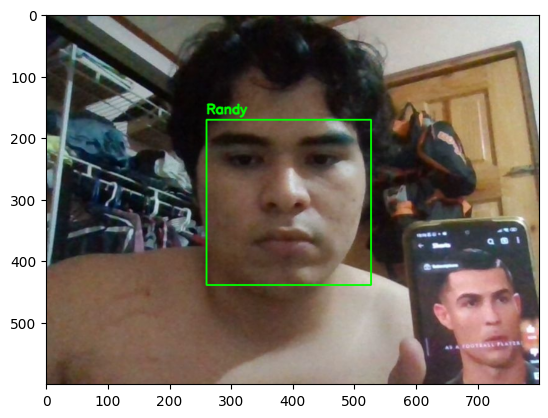

Type: Student
Name: Cristiano
ID: 337478
Age: 35
Birthday: 1990-03-12
Nationality: portugues
Phone book:
  cr7: 7770777
Emails:
  cri@gmail.com
Address: fthfd
Marital Status: married
Attendance Time: 2023-11-15 15



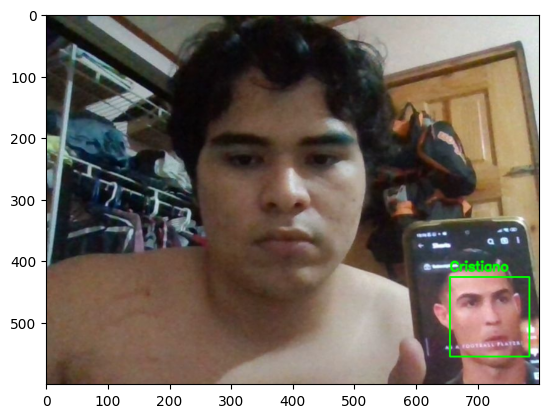

Type: Student
Name: Randy
ID: 504470682
Age: 20
Birthday: 2003-02-24
Nationality: costarricense
Phone book:
  shbd: 62307737
Emails:
  siroko147@gmail.com
Address: barrio san roque
Marital Status: loner
Attendance Time: 2023-11-15 15



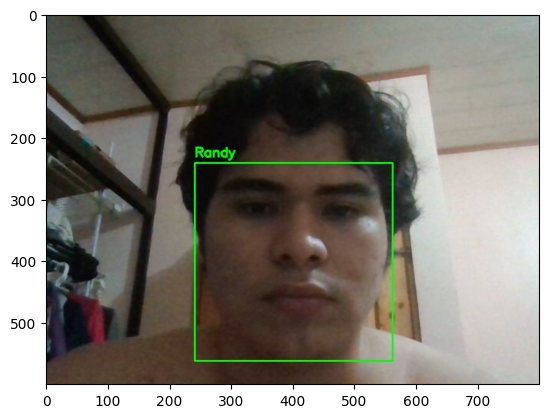

In [68]:


def show_image(image_path, face_info=None):
    """
    This function displays an image with an optional square and name on the face.

    Args:
        image_path (str): Path to the image.
        face_info (tuple): Information about the face (top, right, bottom, left, name).
    Returns:
        None
    """
    img = cv2.imread(image_path)

    if face_info is not None:
        top, right, bottom, left, name = face_info
        # Draws a rectangle around the face
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

        # Adds the name above the face
        cv2.putText(
            img,
            name,
            (left, top - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    plt.show()


def consulta6():
    all_people = {}

    # Combine all the people instances into one list
    all_people_instances = registered_student + registered_professor + registered_miscelaneous

    for person in all_people_instances:
        all_people[person.name] = person

    course_code = input("Enter the course code: ")

    for attendance in attendance_list0:
        if course_code in attendance:
            attendance_list = attendance[course_code]
            print(f"Course Code: {course_code}")

            for person_info in attendance_list:
                name, img_path, (top, right, bottom, left), attendance_time = person_info

                if name in all_people:
                    person_instance = all_people[name]
                    person_type = "Student" if isinstance(person_instance, Estudiante) else "Professor" if isinstance(person_instance, Profesor) else "Miscellaneous"
                else:
                    person_type = "Unknown"
                    person_instance = None

                print(f"Type: {person_type}")

                if person_instance:
                    # Extract information directly from the instance
                    print(f"Name: {person_instance.name}")
                    print(f"ID: {person_instance.id}")
                    print(f"Age: {person_instance.age}")
                    print(f"Birthday: {person_instance.birthday}")
                    print(f"Nationality: {person_instance.nationality}")

                    # Print the contents of the Phone book without dictionary structure
                    print("Phone book:")
                    for phone_key, phone_value in person_instance.phone_number.items():
                        print(f"  {phone_key}: {phone_value}")

                    # Print the contents of the Emails without list structure
                    print("Emails:")
                    for email in person_instance.emails:
                        print(f"  {email}")

                    print(f"Address: {person_instance.address}")
                    print(f"Marital Status: {person_instance.marital_status}")

                print(f"Attendance Time: {attendance_time}")
                print()
                show_image(img_path, (top, right, bottom, left, name))
            break
    else:
        print(f"No attendance found for course code: {course_code}")

# Calls the function
consulta6()

In [74]:
def show_image(image_path, face_info=None):
    """
    This function displays an image with an optional square and name on the face.

    Args:
        image_path (str): Path to the image.
        face_info (tuple): Information about the face (top, right, bottom, left, name).
    Returns:
        None
    """
    img = cv2.imread(image_path)

    if face_info is not None:
        top, right, bottom, left, name = face_info
        # Draws a rectangle around the face
        cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)

        # Adds the name above the face
        cv2.putText(
            img,
            name,
            (left, top - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(widgets.Image(value=cv2.imencode('.png', img_cvt)[1].tobytes()))

def consulta6(course_code_widget):
    all_people = {}

    # Combine all the people instances into one list
    all_people_instances = registered_student + registered_professor + registered_miscelaneous

    for person in all_people_instances:
        all_people[person.name] = person

    course_code = course_code_widget.value

    for attendance in attendance_list0:
        if course_code in attendance:
            attendance_list = attendance[course_code]
            display(widgets.HTML(f"<h3>Course Code: {course_code}</h3>"))

            for person_info in attendance_list:
                name, img_path, (top, right, bottom, left), attendance_time = person_info

                if name in all_people:
                    person_instance = all_people[name]
                    person_type = "Student" if isinstance(person_instance, Estudiante) else "Professor" if isinstance(person_instance, Profesor) else "Miscellaneous"
                else:
                    person_type = "Unknown"
                    person_instance = None

                display(widgets.HTML(f"<p>Type: {person_type}</p>"))

                if person_instance:
                    # Extract information directly from the instance
                    display(widgets.HTML(f"<b>Name:</b> {person_instance.name}"))
                    display(widgets.HTML(f"<b>ID:</b> {person_instance.id}"))
                    display(widgets.HTML(f"<b>Age:</b> {person_instance.age}"))
                    display(widgets.HTML(f"<b>Birthday:</b> {person_instance.birthday}"))
                    display(widgets.HTML(f"<b>Nationality:</b> {person_instance.nationality}"))

                    # Display the contents of the Phone book without dictionary structure
                    display(widgets.HTML("<b>Phone book:</b>"))
                    for phone_key, phone_value in person_instance.phone_number.items():
                        display(widgets.HTML(f"&nbsp;&nbsp;{phone_key}: {phone_value}"))

                    # Display the contents of the Emails without list structure
                    display(widgets.HTML("<b>Emails:</b>"))
                    for email in person_instance.emails:
                        display(widgets.HTML(f"&nbsp;&nbsp;{email}"))
                    display(widgets.HTML(f"<b>Address:</b> {person_instance.carreer}"))
                    display(widgets.HTML(f"<b>Address:</b> {person_instance.address}"))
                    display(widgets.HTML(f"<b>Marital Status:</b> {person_instance.marital_status}"))

                display(widgets.HTML(f"<p>Attendance Time: {attendance_time}</p>"))
                show_image(img_path, (top, right, bottom, left, name))
            break
    else:
        display(widgets.HTML(f"<p>No attendance found for course code: {course_code}</p>"))

# Create a Text widget for entering the course code
course_code_input = widgets.Text(description="Enter Course Code:")

# Create a Button to trigger the function
run_button = widgets.Button(description="Run")
run_button.on_click(lambda x: consulta6(course_code_input))

# Display the widgets
display(course_code_input, run_button)

Text(value='', description='Enter Course Code:')

Button(description='Run', style=ButtonStyle())

HTML(value='<h3>Course Code: IC001</h3>')

HTML(value='<p>Type: Student</p>')

HTML(value='<b>Name:</b> Randy')

HTML(value='<b>ID:</b> 504470682')

HTML(value='<b>Age:</b> 20')

HTML(value='<b>Birthday:</b> 2003-02-24')

HTML(value='<b>Nationality:</b> costarricense')

HTML(value='<b>Phone book:</b>')

HTML(value='&nbsp;&nbsp;shbd: 62307737')

HTML(value='<b>Emails:</b>')

HTML(value='&nbsp;&nbsp;siroko147@gmail.com')

HTML(value='<b>Address:</b> barrio san roque')

HTML(value='<b>Marital Status:</b> loner')

HTML(value='<p>Attendance Time: 2023-11-15 15</p>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

HTML(value='<p>Type: Student</p>')

HTML(value='<b>Name:</b> Cristiano')

HTML(value='<b>ID:</b> 337478')

HTML(value='<b>Age:</b> 35')

HTML(value='<b>Birthday:</b> 1990-03-12')

HTML(value='<b>Nationality:</b> portugues')

HTML(value='<b>Phone book:</b>')

HTML(value='&nbsp;&nbsp;cr7: 7770777')

HTML(value='<b>Emails:</b>')

HTML(value='&nbsp;&nbsp;cri@gmail.com')

HTML(value='<b>Address:</b> fthfd')

HTML(value='<b>Marital Status:</b> married')

HTML(value='<p>Attendance Time: 2023-11-15 15</p>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

HTML(value='<p>Type: Student</p>')

HTML(value='<b>Name:</b> Randy')

HTML(value='<b>ID:</b> 504470682')

HTML(value='<b>Age:</b> 20')

HTML(value='<b>Birthday:</b> 2003-02-24')

HTML(value='<b>Nationality:</b> costarricense')

HTML(value='<b>Phone book:</b>')

HTML(value='&nbsp;&nbsp;shbd: 62307737')

HTML(value='<b>Emails:</b>')

HTML(value='&nbsp;&nbsp;siroko147@gmail.com')

HTML(value='<b>Address:</b> barrio san roque')

HTML(value='<b>Marital Status:</b> loner')

HTML(value='<p>Attendance Time: 2023-11-15 15</p>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

## Arbol de consulta 7 y 8

In [95]:
class Nodo():
    """Clase Nodo"""

    def __init__(self, estudiante):
        self.izquierdo = None
        self.derecho = None
        self.estudiante = estudiante

class Arbol():
    """Clase Arbol"""

    def __init__(self):
        self.raiz = None

    def insertar(self, estudiante):
        if self.raiz is None:
            self.raiz = Nodo(estudiante)
        else:
            self._insertar(estudiante, self.raiz)

    def _insertar(self, estudiante, nodo):
        if estudiante.age < nodo.estudiante.age:
            if nodo.izquierdo is not None:
                self._insertar(estudiante, nodo.izquierdo)
            else:
                nodo.izquierdo = Nodo(estudiante)
        else:
            if nodo.derecho is not None:
                self._insertar(estudiante, nodo.derecho)
            else:
                nodo.derecho = Nodo(estudiante)

    def display_info_batched(self, estudiante, output=None):
        if output is not None:
            with output:
                info_html = [
                    f"<b>Name:</b> {estudiante.name}",
                    f"<b>ID:</b> {estudiante.id}",
                    f"<b>Age:</b> {estudiante.age}",
                    f"<b>Birthday:</b> {estudiante.birthday}",
                    f"<b>Nationality:</b> {estudiante.nationality}",
                ]

                # Append other information as needed

                # Display the contents of the Phone book without dictionary structure
                info_html.append("<b>Phone book:</b>")
                for phone_key, phone_value in estudiante.phone_number.items():
                    info_html.append(f"&nbsp;&nbsp;{phone_key}: {phone_value}")

                # Display the contents of the Emails without list structure
                info_html.append("<b>Emails:</b>")
                for email in estudiante.emails:
                    info_html.append(f"&nbsp;&nbsp;{email}")

                info_html.append(f"<b>Address:</b> {estudiante.carreer}")
                info_html.append(f"<b>Address:</b> {estudiante.address}")
                info_html.append(f"<b>Marital Status:</b> {estudiante.marital_status}")

                display(HTML("<br>".join(info_html)))
                display(widgets.HTML("<hr>"))

    def en_orden_batched(self, nodo, output=None):
        if nodo is not None:
            self.en_orden_batched(nodo.izquierdo, output)
            self.display_info_batched(nodo.estudiante, output)
            self.en_orden_batched(nodo.derecho, output)

    def en_pre_orden_batched(self, nodo, output=None):
        if nodo is not None:
            self.display_info_batched(nodo.estudiante, output)
            self.en_pre_orden_batched(nodo.izquierdo, output)
            self.en_pre_orden_batched(nodo.derecho, output)


# Example usage:

# Assuming output_widget is already defined
output_widget = widgets.Output()
display(output_widget)

# Create an instance of the tree
my_tree = Arbol()

# Assume registered_course, registered_student, etc., are defined in your environment
for cursito in registered_course:
    estudiantitos = cursito.lista_estudiantes
    for ste in estudiantitos:
        for ax in registered_student:
            if ste == ax.name:
                my_tree.insertar(ax)

# Display the information using en_orden_batched
my_tree.en_orden_batched(my_tree.raiz, output_widget)

my_tree.en_pre_orden_batched(my_tree.raiz, output_widget)

Output()

## Consulta 9

In [69]:
def display_student_information(student_name, student_list):
    """
    This function displays the student information

    Args:
        student_name(str): Name of the student to display
        student_list(list): List of student instances

    Returns:
        student_info(Estudiante): Student instance
        None: Returned if the student is not found
    """
    # Iterates through student_list and returns the matching student instance
    for student in student_list:
        if student.name == student_name:
            return student  # Return the student instance

    return None  # Return None if the student is not found

def leer_mayorasis(lista):
    """
    This function looks for the student who appears most in the "lista" list

    Args:
        lista(list): The main list

    Returns:
        most_common_names(list): List of the most common names
    """
    # Creates a dictionary, a list, and an augment to count and store the most common name that appears in the list
    name_counts = {}
    max_count = 0
    most_common_names = []

    # Iterates through lista and finds the name that appears the most times
    for name in lista:
        if name in name_counts:
            name_counts[name] += 1
        else:
            name_counts[name] = 1

        if name_counts[name] > max_count:
            most_common_names = [name]
            max_count = name_counts[name]
        elif name_counts[name] == max_count:
            most_common_names.append(name)

    # Return a list of the most common names
    return most_common_names

def consul9():
    """
    This function shows the student who attended a course the most times

    Args:
        attendance_list2(list): List of course attendance
        display_student_information(function): Function to display student information
        leer_mayorasis(function): Function to find the student who appears the most

    Returns:
        None
    """
    code = input("Write the code you would like to check: ")
    most_common_people = []

    # Iterates through attendance_list2 and finds the course attendance
    for dictionary in attendance_list2:
        if code in dictionary:
            most_common_people = leer_mayorasis(dictionary[code])

    print("The students who attended the most to this course were:")

    # Iterates through most_common_people and displays student information
    for most_common_person in most_common_people:
        student_instance = display_student_information(most_common_person, registered_student)
        if student_instance:
            # Displays the student information
            print("Student Information:")
            print(f"Name: {student_instance.name}")
            print(f"ID: {student_instance.id}")
            print(f"Age: {student_instance.age}")
            print(f"Birthday: {student_instance.birthday}")
            print(f"Nationality: {student_instance.nationality}")

            # Prints the contents of the Phone book without dictionary structure
            print("Phone Book:")
            for pb_key, pb_value in student_instance.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Prints the contents of the Emails without list structure
            print("Emails:")
            for email in student_instance.emails:
                print(f"  {email}")

            print(f"Address: {student_instance.address}")
            print(f"Career: {student_instance.carreer}")
            print(f"Marital Status: {student_instance.marital_status}\n")

# Calls the function
consul9()

Write the code you would like to check: IC001
The students who attended the most to this course were:
Student Information:
Name: Randy
ID: 504470682
Age: 20
Birthday: 2003-02-24
Nationality: costarricense
Phone Book:
  shbd: 62307737
Emails:
  siroko147@gmail.com
Address: barrio san roque
Career: Ing computation
Marital Status: loner



## Consulta 10

In [70]:
def display_student_information(student_name, student_list):
    """
    This function displays the student information

    Args:
        student_name(str): Name of the student to display
        student_list(list): List of student instances

    Returns:
        student_info(Estudiante): Student instance
        None: Returned if the student is not found
    """
    # Iterates through student_list and returns the matching student instance
    for student in student_list:
        if student.name == student_name:
            return student  # Return the student instance

    return None  # Return None if the student is not found

def menor_lista(lista):
    """
    This function looks for the student who appears the least in the "lista" list

    Args:
        lista(list): The main list

    Returns:
        least_common_names(list): List of the least common names
    """
    # Creates a dictionary, a list, and an augment to count and store the least common name that appears in the list
    least_common_names = []
    min_count = 100000
    name_counts = {}

    # Iterates through lista to set a counter
    for name in lista:
        if name in name_counts:
            name_counts[name] += 1
        else:
            name_counts[name] = 1

    # Iterates through name_counts and finds the name that appears the least times
    for name, count in name_counts.items():
        if count < min_count:
            least_common_names = [name]
            min_count = count
        elif count == min_count:
            least_common_names.append(name)

    # Return a list of the least common names
    return least_common_names

def consul10():
    """
    This function shows the student who attended a course the least times

    Args:
        attendance_list2(list): List of course attendance
        display_student_information(function): Function to display student information

    Returns:
        None
    """
    code = input("Write the code you would like to checkout: ")

    # Iterates through attendance_list2 and finds the course attendance
    for dictionary in attendance_list2:
        if code in dictionary:
            least_common_people = menor_lista(dictionary[code])

    print("The students who attended the least to this course were:")
    # Iterates through least_common_people and displays student information
    for least_common_person in least_common_people:
        student_info = display_student_information(least_common_person, registered_student)
        if student_info:
            # Displays the student information
            print("Student Information:")
            print(f"Name: {student_info.name}")
            print(f"ID: {student_info.id}")
            print(f"Age: {student_info.age}")
            print(f"Birthday: {student_info.birthday}")
            print(f"Nationality: {student_info.nationality}")

            # Prints the contents of the Phone book without dictionary structure
            print("Phone Book:")
            for pb_key, pb_value in student_info.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Prints the contents of the Emails without list structure
            print("Emails:")
            for email in student_info.emails:
                print(f"  {email}")

            print(f"Address: {student_info.address}")
            print(f"Career: {student_info.carreer}")
            print(f"Marital Status: {student_info.marital_status}\n")

# Calls the function
consul10()




Write the code you would like to checkout: IC001
The students who attended the least to this course were:
Student Information:
Name: Cristiano
ID: 337478
Age: 35
Birthday: 1990-03-12
Nationality: portugues
Phone Book:
  cr7: 7770777
Emails:
  cri@gmail.com
Address: fthfd
Career: ing computation
Marital Status: married



## Consulta 11

Enter the course code: IC001
The time with the most attendees for course IC001: 2023-11-15 15
Number of attendees at that time: 3
Attendees' Information:

Type: Student
Name: Randy
ID: 504470682
Age: 20
Birthday: 2003-02-24
Nationality: costarricense
Phone Book:
  shbd: 62307737
Emails:
  siroko147@gmail.com
Address: barrio san roque
Marital Status: loner
Attendance Time: 2023-11-15 15



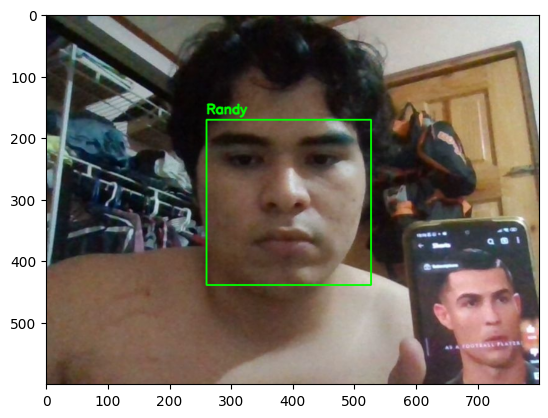


Type: Student
Name: Cristiano
ID: 337478
Age: 35
Birthday: 1990-03-12
Nationality: portugues
Phone Book:
  cr7: 7770777
Emails:
  cri@gmail.com
Address: fthfd
Marital Status: married
Attendance Time: 2023-11-15 15



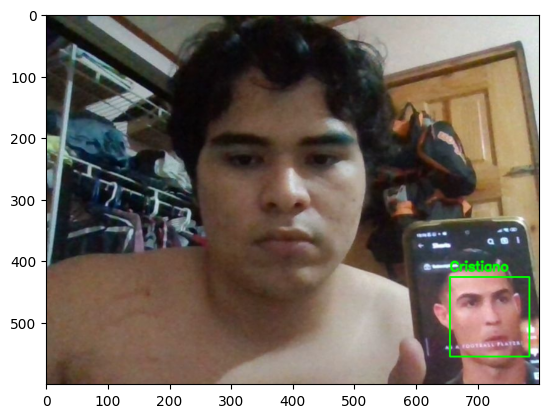


Type: Student
Name: Randy
ID: 504470682
Age: 20
Birthday: 2003-02-24
Nationality: costarricense
Phone Book:
  shbd: 62307737
Emails:
  siroko147@gmail.com
Address: barrio san roque
Marital Status: loner
Attendance Time: 2023-11-15 15



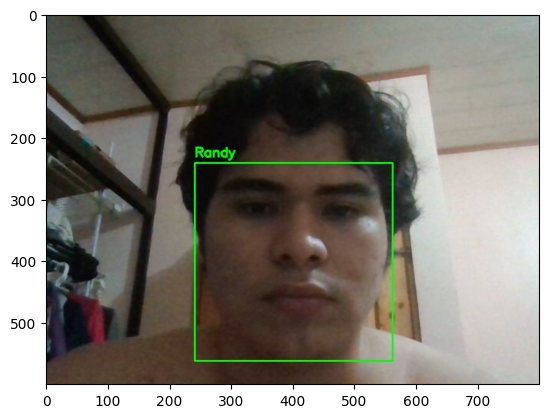

In [71]:

def consulta11():
    """
    Indicates for a course at which time the most people reported and the number of people that attended.

    Args:
        registered_student(list): list of the students
        registered_professor(list): list of the teachers
        registered_miscelaneous(list): list of the miscellaneous

    Returns:
        student_info_list(list): list of student information dictionaries
    """
    # Creates a dictionary to easily access student, professor, and miscellaneous information by name
    all_people = {}

    # Combine all the people instances into one list
    all_people_instances = registered_student + registered_professor + registered_miscelaneous

    for person in all_people_instances:
        all_people[person.name] = person

    course_code = input("Enter the course code: ")

    # Dictionary to store attendance counts for each time slot
    time_slot_counts = {}

    # Iterates through the reported_attendance list
    for attendance in attendance_list3:
        for time_slot, attendance_data in attendance.items():
            if course_code in attendance_data:
                attendance_count = len(attendance_data[course_code])
                time_slot_counts[time_slot] = attendance_count

    # Finds the time slot with the most attendees
    max_attendance_time = max(time_slot_counts, key=time_slot_counts.get)
    max_attendance_count = time_slot_counts[max_attendance_time]

    if max_attendance_time:
        print(f"The time with the most attendees for course {course_code}: {max_attendance_time}")
        print(f"Number of attendees at that time: {max_attendance_count}")
        print("Attendees' Information:")

        # Iterates through attendance_list0 to find attendees at the specified time
        for attendance_data in attendance_list0:
            if course_code in attendance_data:
                attendance_list = attendance_data[course_code]

                # Iterates through attendees and display their information
                for person_info in attendance_list:
                    name, img_path, (top, right, bottom, left), attendance_time = person_info

                    # Checks if the reported person is a student, professor, or miscellaneous
                    if name in all_people:
                        person_instance = all_people[name]
                        person_type = "Student" if isinstance(person_instance, Estudiante) else "Professor" if isinstance(person_instance, Profesor) else "Miscellaneous"
                    else:
                        person_type = "Unknown"
                        person_instance = None

                    print(f"\nType: {person_type}")

                    if person_instance:
                        # Extract information directly from the instance
                        print(f"Name: {person_instance.name}")
                        print(f"ID: {person_instance.id}")
                        print(f"Age: {person_instance.age}")
                        print(f"Birthday: {person_instance.birthday}")
                        print(f"Nationality: {person_instance.nationality}")

                        # Print the contents of the Phone book without dictionary structure
                        print("Phone Book:")
                        for phone_key, phone_value in person_instance.phone_number.items():
                            print(f"  {phone_key}: {phone_value}")

                        # Print the contents of the Emails without list structure
                        print("Emails:")
                        for email in person_instance.emails:
                            print(f"  {email}")

                        print(f"Address: {person_instance.address}")
                        print(f"Marital Status: {person_instance.marital_status}")

                    print(f"Attendance Time: {attendance_time}")
                    print()
                    # Displays the image with a square on the face and the person's name
                    show_image(img_path, (top, right, bottom, left, name))

    else:
        print(f"No attendance records found for course code: {course_code}")

# Calls the function
consulta11()


## Consulta 12

In [ ]:


def quicksort(arr):
    """
    This function sorts a list of students based on their age using the quicksort algorithm.

    Args:
        arr (list): List of student instances

    Returns:
        list: Sorted list of student instances (from oldest to youngest)
    """
    if len(arr) <= 1:
        return arr
    else:
        pivot = arr[0]
        less = [x for x in arr[1:] if x.age <= pivot.age]
        greater = [x for x in arr[1:] if x.age > pivot.age]
        return quicksort(greater) + [pivot] + quicksort(less)

def consul12():
    """
    This function sorts the students enrolled in a specific course from oldest to youngest using the quicksort algorithm.

    Returns:
        None
    """
    codig = input("Write the code of the course: ")

    # Find the enrolled students in the specified course
    enrolled_students = []
    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    # Verify if students are enrolled in the course
    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student instances in the same order as enrolled_students
        sorted_students = []

        # Match enrolled students with registered_student instances
        for student_name in enrolled_students:
            for student_instance in registered_student:
                if student_instance.name == student_name:
                    sorted_students.append(student_instance)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student instances by age using the quicksort function
        sorted_students = quicksort(sorted_students)

        print("The enrolled students in this course from oldest to youngest are: ")
        # Print the information of the students
        for student_instance in sorted_students:
            print(f"Name: {student_instance.name}")
            print(f"ID: {student_instance.id}")
            print(f"Age: {student_instance.age}")
            print(f"Birthday: {student_instance.birthday}")
            print(f"Nationality: {student_instance.nationality}")

            # Print the contents of the Phone book without dictionary structure
            print("Phone book:")
            for pb_key, pb_value in student_instance.phone_number.items():
                print(f"  {pb_key}: {pb_value}")

            # Print the contents of the Emails without list structure
            print("Emails:")
            for email in student_instance.emails:
                print(f"  {email}")

            print(f"Address: {student_instance.address}")
            print(f"Career: {student_instance.carreer}")
            print(f"Marital Status: {student_instance.marital_status}\n")

# Calls the function
consul12()


Write the code of the course: IC001
The enrolled students in this course from oldest to youngest are: 
Name: Cristiano
ID: diwnindi3
Age: 38
Birthday: diw
Nationality: portuguese
Phone book:
  nid: 4948388
  suiuu: 9338378
Emails:
  sindn@gmail.com
Address: kdnin
Career: ing computtatino
Marital Status: married

Name: Randy
ID: 504470682
Age: 20
Birthday: 24/02/2003
Nationality: Costa rican
Phone book:
  ran: 62307737
Emails:
  siroko147@gmail.com
  randydowning147@estudiantec.cr
Address: barrio san roque
Career: ing computation
Marital Status: alone



In [52]:
def quicksort(arr):
    """
    This function sorts a list of students based on their age using the quicksort algorithm.

    Args:
        arr (list): List of student instances

    Returns:
        list: Sorted list of student instances (from oldest to youngest)
    """
    if len(arr) <= 1:
        return arr
    else:
        pivot = arr[0]
        less = [x for x in arr[1:] if x.age <= pivot.age]
        greater = [x for x in arr[1:] if x.age > pivot.age]
        return quicksort(greater) + [pivot] + quicksort(less)

def consul12():
    """
    This function sorts the students enrolled in a specific course from oldest to youngest using the quicksort algorithm.

    Returns:
        None
    """
    codig = input("Write the code of the course: ")

    # Find the enrolled students in the specified course
    enrolled_students = []
    for course_dict in registered_students_in_courses:
        if codig in course_dict:
            enrolled_students = course_dict[codig]

    # Verify if students are enrolled in the course
    if not enrolled_students:
        print("No students are enrolled in this course.")
    else:
        # Create a list to store student instances in the same order as enrolled_students
        sorted_students = []

        # Match enrolled students with registered_student instances
        for student_name in enrolled_students:
            for student_instance in registered_student:
                if student_instance.name == student_name:
                    sorted_students.append(student_instance)
                    break  # Exit the inner loop after finding a match

        # Sort the list of student instances by age using the quicksort function
        sorted_students = quicksort(sorted_students)

        print("The enrolled students in this course from oldest to youngest are: ")
        # Print the information of the students
        def display_student_info(student_instance):
            info_html = f"""
                <h3>Name: {student_instance.name}</h3>
                <p>ID: {student_instance.id}</p>
                <p>Age: {student_instance.age}</p>
                <p>Birthday: {student_instance.birthday}</p>
                <p>Nationality: {student_instance.nationality}</p>

                <h4>Phone book:</h4>
                <ul>
                    {"".join(f"<li>{pb_key}: {pb_value}</li>" for pb_key, pb_value in student_instance.phone_number.items())}
                </ul>

                <h4>Emails:</h4>
                <ul>
                    {"".join(f"<li>{email}</li>" for email in student_instance.emails)}
                </ul>

                <p>Address: {student_instance.address}</p>
                <p>Career: {student_instance.carreer}</p>
                <p>Marital Status: {student_instance.marital_status}</p>
                <hr/>
            """
            display(HTML(info_html))

        # Assuming sorted_students is a list of student instances
        for student_instance in sorted_students:
            display_student_info(student_instance)



Text(value='', description='Course Code:')

Button(description='Run', style=ButtonStyle())

# Link de imagenes utilizadas y obtenidas

[Link a la carpeta de imagenes usadas e imagenes obtenidas](https://drive.google.com/drive/folders/1hA7QlFRvi8RJiykNM1jvPJhhH7FZoKPp?usp=sharing)